In [ ]:
# 나눔 폰트 설치
!apt-get update -qq
!apt-get install fonts-nanum -qq
!fc-cache -fv
!rm -rf ~/.cache/matplotlib

# matplotlib에 폰트 설정
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 나눔고딕 폰트 경로 설정
font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'

# 폰트 직접 등록 방법
fe = fm.FontEntry(
 fname=font_path,
 name='NanumGothic')
fm.fontManager.ttflist.insert(0, fe)

# 폰트 설정 적용
plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False # 마이너스 기호 표시 문제 해결

!pip install torch-scatter torch-sparse torch-cluster torch-spline-conv -f https://data.pyg.org/whl/torch-2.6.0+cu124.html
!pip install torch-geometric-temporal




W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Selecting previously unselected package fonts-nanum.
(Reading database ... 126111 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no

In [ ]:
# Google Drive 연결

from google.colab import drive
drive.mount('/content/gdrive')

KeyboardInterrupt: 

In [ ]:
#데이터 준비 및 그래프 구성

데이터 로드 및 전처리 중...
시간적 그래프 데이터셋 생성 중...
훈련 데이터셋 크기: 206
테스트 데이터셋 크기: 52
모델 훈련 시작...
에폭 5/50, 훈련 손실: 0.0054, 테스트 손실: 0.0057
에폭 10/50, 훈련 손실: 0.0055, 테스트 손실: 0.0057
에폭 15/50, 훈련 손실: 0.0054, 테스트 손실: 0.0058
에폭 20/50, 훈련 손실: 0.0054, 테스트 손실: 0.0055
에폭 25/50, 훈련 손실: 0.0054, 테스트 손실: 0.0058
에폭 30/50, 훈련 손실: 0.0054, 테스트 손실: 0.0054
에폭 35/50, 훈련 손실: 0.0053, 테스트 손실: 0.0056
에폭 40/50, 훈련 손실: 0.0054, 테스트 손실: 0.0055
에폭 45/50, 훈련 손실: 0.0055, 테스트 손실: 0.0057
에폭 50/50, 훈련 손실: 0.0054, 테스트 손실: 0.0057
GNN 점수 추출 중...
원본 데이터와 GNN 점수 병합 중...
원본 데이터와 GNN 점수가 'combined_data_with_gnn_scores.csv'에 저장되었습니다.
그래프 구조 시각화 중...
임베딩 시각화 중...
GNN 점수와 rebalance_priority 간 상관관계: 0.5809
모든 처리가 완료되었습니다.


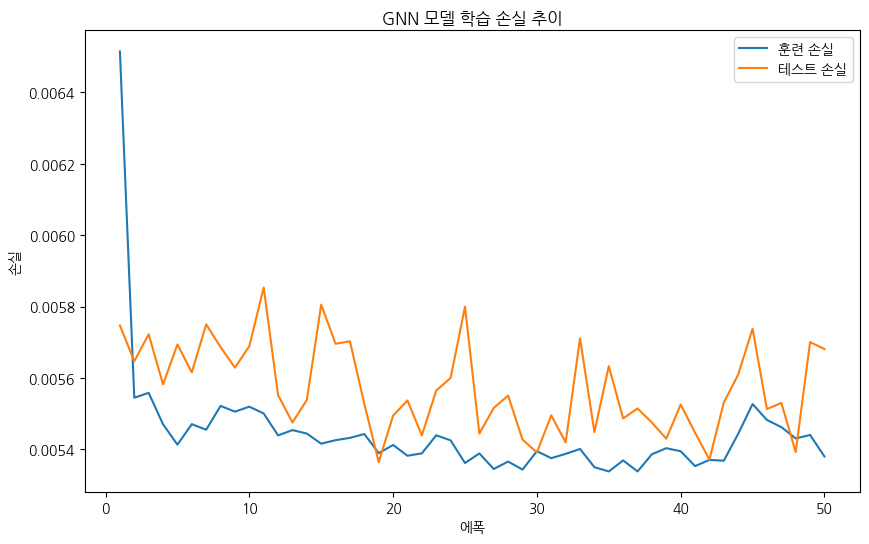

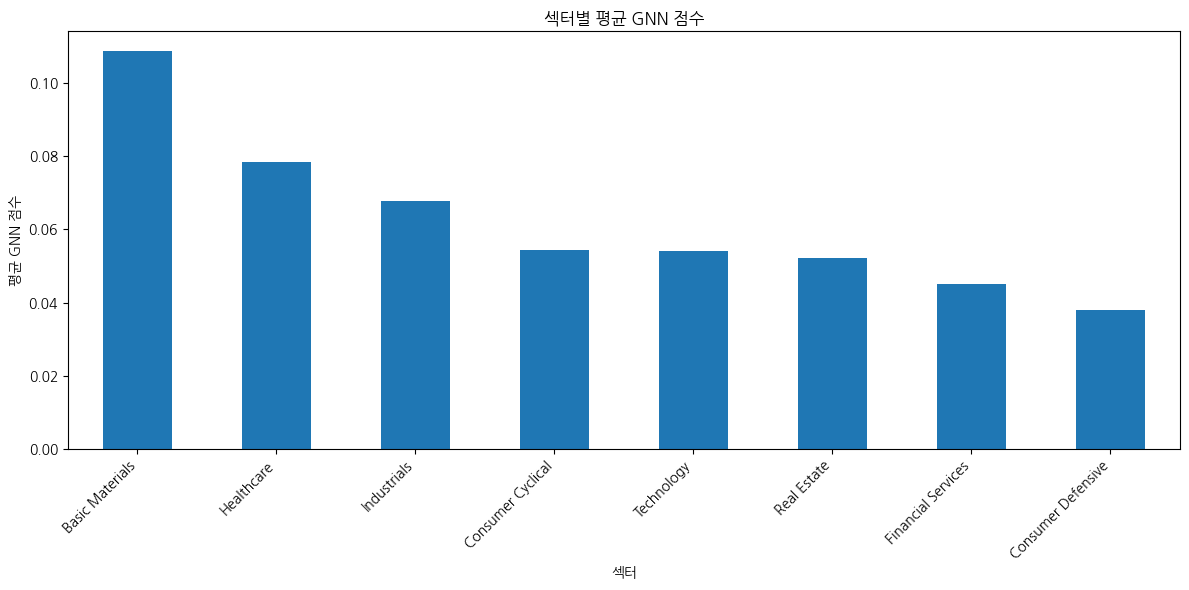

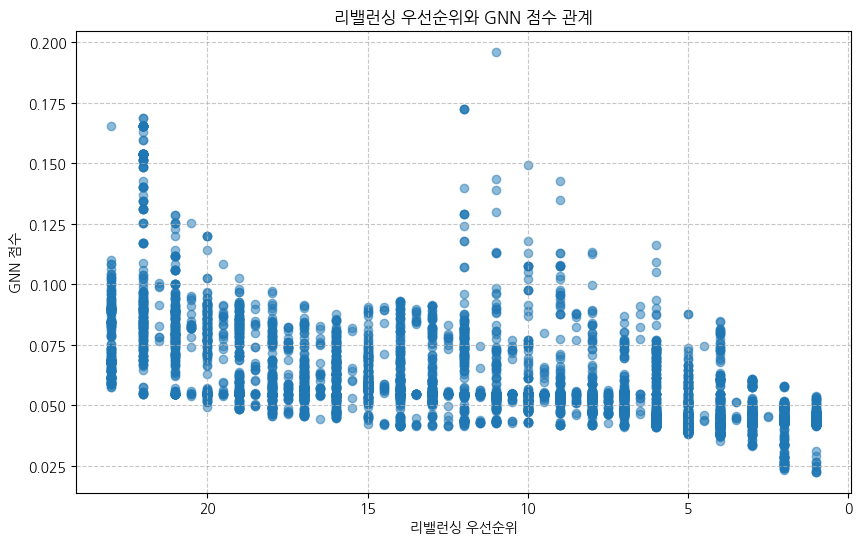

In [12]:
# 필요한 라이브러리 임포트
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from torch.nn import Linear, ReLU, Dropout
from scipy.stats import rankdata
import networkx as nx
from sklearn.manifold import TSNE

# --- 시각화 함수 추가 ---
def visualize_graph(snapshot, symbols, sectors, date, top_n=20):
    """
    특정 날짜의 그래프 구조를 시각화하는 함수
    - top_n: 상위 N개 노드만 표시 (복잡도 감소)
    """
    plt.figure(figsize=(15, 10))
    G = nx.Graph()
    edge_weights = snapshot.edge_attr.numpy().flatten()
    if len(edge_weights) > 0:
        top_edges = np.argsort(edge_weights)[-top_n:]
    else:
        top_edges = []
    for idx in range(len(symbols)):
        G.add_node(idx, symbol=symbols[idx], sector=sectors.get(idx, 'Unknown'))
    for i, (src, dst) in enumerate(snapshot.edge_index.t().numpy()):
        if i in top_edges or len(top_edges) == 0:
            weight = edge_weights[i] if len(edge_weights) > 0 else 1.0
            G.add_edge(src, dst, weight=float(weight))
    # 섹터별 색상 매핑 (Unknown 포함)
    unique_sectors = list(set(sectors.values()).union({'Unknown'}))
    colors = plt.cm.tab20(np.linspace(0, 1, len(unique_sectors)))
    sector_color = {sector: colors[i] for i, sector in enumerate(unique_sectors)}
    # 노드 색상 지정 (KeyError 방지)
    node_colors = [sector_color.get(sectors.get(node, 'Unknown'), 'gray') for node in G.nodes()]
    edge_weights = [G[u][v]['weight']*3 for u,v in G.edges()]
    nx.draw_networkx_nodes(G, pos=nx.spring_layout(G, seed=42, k=0.3), node_size=300, node_color=node_colors, alpha=0.8)
    nx.draw_networkx_edges(G, pos=nx.spring_layout(G, seed=42, k=0.3), width=edge_weights, edge_color='gray', alpha=0.5)
    labels = {node: G.nodes[node]['symbol'] for node in G.nodes()}
    nx.draw_networkx_labels(G, pos=nx.spring_layout(G, seed=42, k=0.3), labels=labels, font_size=8)
    patches = [plt.Line2D([0], [0], marker='o', color='w',
                          markerfacecolor=sector_color[s], markersize=10, label=s)
               for s in unique_sectors]
    plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.title(f"Stock Connections Graph ({date})\nEdge Thickness = Correlation Strength")
    plt.tight_layout()
    plt.savefig(f'stock_network_{date}.png', bbox_inches='tight')
    plt.close()

def visualize_embeddings(embeddings_list, symbols, dates, sample_symbols=10):
    """
    시간에 따른 노드 임베딩의 변화를 시각화
    """
    all_embeddings = torch.stack([emb.cpu() if isinstance(emb, torch.Tensor) else torch.tensor(emb) for emb in embeddings_list])
    all_embeddings = all_embeddings.numpy()  # (time, node, dim)
    n_time, n_node, dim = all_embeddings.shape
    sample_idx = np.random.choice(n_node, size=min(sample_symbols, n_node), replace=False)
    plt.figure(figsize=(15, 8))
    tsne = TSNE(n_components=2, perplexity=30, random_state=42)
    tsne_input = all_embeddings.reshape(-1, dim)
    transformed = tsne.fit_transform(tsne_input)
    transformed = transformed.reshape(n_time, n_node, 2)
    for i, idx in enumerate(sample_idx):
        symbol_embeddings = [transformed[t, idx] for t in range(n_time)]
        x = [e[0] for e in symbol_embeddings]
        y = [e[1] for e in symbol_embeddings]
        plt.plot(x, y, marker='o', linestyle='-', markersize=5, label=f'{symbols[idx]} ({i+1})')
    plt.xlabel('t-SNE 1')
    plt.ylabel('t-SNE 2')
    plt.title('Temporal Evolution of Stock Embeddings (t-SNE projection)')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig('temporal_embeddings_evolution.png')
    plt.close()

# CSV 파일 로드
def load_data(file_path):
    df = pd.read_csv(file_path)
    # 결측 섹터 처리
    if 'Sector' in df.columns:
        df['Sector'] = df['Sector'].fillna('Unknown')
    dates = df['Date'].unique()
    dates.sort()
    symbols = df['Symbol'].unique()
    symbol_to_idx = {symbol: idx for idx, symbol in enumerate(symbols)}
    factor_cols = ['Beta_Factor', 'Value_Factor', 'Size_Factor', 'Momentum_Factor', 'Volatility_Factor']
    return df, dates, symbols, symbol_to_idx, factor_cols

def temporal_signal_split_custom(temporal_dataset, train_ratio=0.8):
    train_snapshots = int(train_ratio * len(temporal_dataset))
    train_dataset = temporal_dataset[:train_snapshots]
    test_dataset = temporal_dataset[train_snapshots:]
    return train_dataset, test_dataset

def create_temporal_graph_dataset(df, dates, symbols, symbol_to_idx, factor_cols):
    temporal_dataset = []
    for date_idx, date in enumerate(dates):
        date_df = df[df['Date'] == date]
        node_features = np.zeros((len(symbols), len(factor_cols)))
        for _, row in date_df.iterrows():
            if row['Symbol'] in symbol_to_idx:
                idx = symbol_to_idx[row['Symbol']]
                node_features[idx] = [row[col] for col in factor_cols]
        node_features = np.nan_to_num(node_features, nan=0.0)
        edge_index = []
        edge_attr = []
        threshold = 0.3
        if date_idx > 0:
            prev_date = dates[date_idx-1]
            prev_date_df = df[df['Date'] == prev_date]
            sectors = {}
            for _, row in date_df.iterrows():
                if row['Symbol'] in symbol_to_idx:
                    sectors[symbol_to_idx[row['Symbol']]] = row.get('Sector', 'Unknown')
            for i in range(len(symbols)):
                for j in range(len(symbols)):
                    if i != j:
                        if i in sectors and j in sectors and sectors[i] == sectors[j]:
                            edge_index.append([i, j])
                            mom_i = node_features[i][3]
                            mom_j = node_features[j][3]
                            correlation = max(0.1, 1 - abs(mom_i - mom_j))
                            edge_attr.append([correlation])
        if len(edge_index) > 0:
            edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
            edge_attr = torch.tensor(edge_attr, dtype=torch.float)
            if edge_attr.dim() == 1:
                edge_attr = edge_attr.view(-1, 1)
        else:
            edge_index = torch.zeros((2, 1), dtype=torch.long)
            edge_attr = torch.ones((1, 1), dtype=torch.float)
        x = torch.tensor(node_features, dtype=torch.float)
        y = np.zeros(len(symbols))
        for _, row in date_df.iterrows():
            if row['Symbol'] in symbol_to_idx:
                idx = symbol_to_idx[row['Symbol']]
                if 'to_rebalance' in row and 'rebalance_priority' in row:
                    if row['to_rebalance'] == 1:
                        y[idx] = row['rebalance_priority'] / 100.0
                    else:
                        y[idx] = 0.0
        y = torch.tensor(y, dtype=torch.float)
        snapshot = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y)
        temporal_dataset.append(snapshot)
    return temporal_dataset

class TemporalGNN(torch.nn.Module):
    def __init__(self, node_features, hidden_channels=32):
        super(TemporalGNN, self).__init__()
        self.conv1 = GCNConv(node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.linear = Linear(hidden_channels, 1)
        self.dropout = Dropout(0.2)
    def forward(self, x, edge_index, edge_attr=None):
        if edge_attr is None:
            edge_weight = None
        else:
            if edge_attr.dim() == 0:
                edge_weight = None
            elif edge_attr.dim() == 1:
                edge_weight = edge_attr
            else:
                edge_weight = edge_attr.view(-1) if edge_attr.numel() > 0 else None
        h = self.conv1(x, edge_index, edge_weight)
        h = F.relu(h)
        h = self.dropout(h)
        h = self.conv2(h, edge_index, edge_weight)
        h = F.relu(h)
        embeddings = h
        predictions = self.linear(h).squeeze()
        return embeddings, predictions

def train_model(model, train_dataset, test_dataset, epochs=50):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
    criterion = torch.nn.MSELoss()
    train_losses = []
    test_losses = []
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for snapshot in train_dataset:
            optimizer.zero_grad()
            edge_attr = snapshot.edge_attr
            if edge_attr is not None and edge_attr.dim() == 0:
                edge_attr = edge_attr.unsqueeze(0).unsqueeze(0)
            elif edge_attr is not None and edge_attr.dim() == 1:
                edge_attr = edge_attr.unsqueeze(1)
            embeddings, predictions = model(snapshot.x, snapshot.edge_index, edge_attr)
            loss = criterion(predictions, snapshot.y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_train_loss = total_loss / len(train_dataset)
        train_losses.append(avg_train_loss)
        model.eval()
        total_loss = 0
        with torch.no_grad():
            for snapshot in test_dataset:
                edge_attr = snapshot.edge_attr
                if edge_attr is not None and edge_attr.dim() == 0:
                    edge_attr = edge_attr.unsqueeze(0).unsqueeze(0)
                elif edge_attr is not None and edge_attr.dim() == 1:
                    edge_attr = edge_attr.unsqueeze(1)
                embeddings, predictions = model(snapshot.x, snapshot.edge_index, edge_attr)
                loss = criterion(predictions, snapshot.y)
                total_loss += loss.item()
        avg_test_loss = total_loss / len(test_dataset)
        test_losses.append(avg_test_loss)
        if (epoch + 1) % 5 == 0:
            print(f"에폭 {epoch+1}/{epochs}, 훈련 손실: {avg_train_loss:.4f}, 테스트 손실: {avg_test_loss:.4f}")
    return train_losses, test_losses

def extract_gnn_scores(model, dataset, symbols, dates):
    model.eval()
    all_scores_dfs = []
    all_embeddings = []
    with torch.no_grad():
        for i, snapshot in enumerate(dataset):
            edge_attr = snapshot.edge_attr
            if edge_attr is not None and edge_attr.dim() == 0:
                edge_attr = edge_attr.unsqueeze(0).unsqueeze(0)
            elif edge_attr is not None and edge_attr.dim() == 1:
                edge_attr = edge_attr.unsqueeze(1)
            current_date = dates[i]
            embeddings, predictions = model(snapshot.x, snapshot.edge_index, edge_attr)
            all_embeddings.append(embeddings)
            date_scores_df = pd.DataFrame({
                'Symbol': symbols,
                'Date': current_date,
                'gnn_scores': predictions.numpy()
            })
            all_scores_dfs.append(date_scores_df)
    scores_df = pd.concat(all_scores_dfs, ignore_index=True)
    return scores_df, all_embeddings

def main(file_path="processed_5factor_model.csv"):
    print("데이터 로드 및 전처리 중...")
    df, dates, symbols, symbol_to_idx, factor_cols = load_data(file_path)
    print("시간적 그래프 데이터셋 생성 중...")
    temporal_dataset = create_temporal_graph_dataset(df, dates, symbols, symbol_to_idx, factor_cols)
    train_dataset, test_dataset = temporal_signal_split_custom(temporal_dataset, train_ratio=0.8)
    print(f"훈련 데이터셋 크기: {len(train_dataset)}")
    print(f"테스트 데이터셋 크기: {len(test_dataset)}")
    node_features = temporal_dataset[0].x.shape[1]
    model = TemporalGNN(node_features=node_features)
    print("모델 훈련 시작...")
    train_losses, test_losses = train_model(model, train_dataset, test_dataset, epochs=50)
    print("GNN 점수 추출 중...")
    scores_df, embeddings = extract_gnn_scores(model, temporal_dataset, symbols, dates)
    print("원본 데이터와 GNN 점수 병합 중...")
    combined_df = df.merge(scores_df, on=['Symbol', 'Date'], how='left')
    output_file = 'combined_data_with_gnn_scores.csv'
    combined_df.to_csv(output_file, index=False)
    print(f"원본 데이터와 GNN 점수가 '{output_file}'에 저장되었습니다.")
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(train_losses) + 1), train_losses, label='훈련 손실')
    plt.plot(range(1, len(test_losses) + 1), test_losses, label='테스트 손실')
    plt.xlabel('에폭')
    plt.ylabel('손실')
    plt.title('GNN 모델 학습 손실 추이')
    plt.legend()
    plt.savefig('training_loss.png')
    # --- 시각화 코드 추가 ---
    print("그래프 구조 시각화 중...")
    sectors_mapping = df.groupby('Symbol')['Sector'].first().to_dict()
    visualize_graph(temporal_dataset[0], symbols, sectors_mapping, dates[0])
    visualize_graph(temporal_dataset[-1], symbols, sectors_mapping, dates[-1])
    print("임베딩 시각화 중...")
    visualize_embeddings(embeddings, symbols, dates)
    return model, combined_df, embeddings

def evaluate_model_results(combined_df):
    correlation = combined_df[['gnn_scores', 'rebalance_priority']].corr().iloc[0, 1]
    print(f"GNN 점수와 rebalance_priority 간 상관관계: {correlation:.4f}")
    sector_avg = combined_df.groupby('Sector')['gnn_scores'].mean().sort_values(ascending=False)
    plt.figure(figsize=(12, 6))
    sector_avg.plot(kind='bar')
    plt.title('섹터별 평균 GNN 점수')
    plt.ylabel('평균 GNN 점수')
    plt.xlabel('섹터')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig('sector_gnn_scores.png')
    plt.figure(figsize=(10, 6))
    plt.scatter(combined_df['rebalance_priority'], combined_df['gnn_scores'], alpha=0.5)
    plt.xlabel('리밸런싱 우선순위')
    plt.ylabel('GNN 점수')
    plt.title('리밸런싱 우선순위와 GNN 점수 관계')
    plt.gca().invert_xaxis()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.savefig('rebalance_vs_gnn.png')

if __name__ == "__main__":
    file_path = "/content/sample_data/processed_daily_5factor_model_20250525.csv"
    model, combined_df, embeddings = main(file_path)
    evaluate_model_results(combined_df)
    print("모든 처리가 완료되었습니다.")
